## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.7]
redice_lr_patient = [5, 10]

In [8]:
from keras.layers import BatchNormalization
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0811 19:30:28.106321  6008 deprecation_wrapper.py:119] From C:\Users\Trenton\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 19:30:28.107317  6008 deprecation_wrapper.py:119] From C:\Users\Trenton\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 19:30:28.110311  6008 deprecation_wrapper.py:119] From C:\Users\Trenton\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 19:30:28.184113  6008 deprecation_wrapper.py:119] From C:\Users\Trenton\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0811 19:30:28.379590  6008 deprecation_wrapper.py:119] From C:\Users\Trenton\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 19:30:28.386571  6008 deprecation_wrapper.py:119] From C:\Users\Trenton\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0811 19:30:28.461410  6008 deprecation.py:323] From C:\Users\Trenton\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 3s 51us/step - loss: 1.2264 - acc: 0.5764 - val_loss: 1.4865 - val_acc: 0.4747
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2065 - acc: 0.5835 - val_loss: 1.4621 - val_acc: 0.4877
Epoch 16/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1849 - acc: 0.5896 - val_loss: 1.4565 - val_acc: 0.4826
Epoch 17/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1668 - acc: 0.5972 - val_loss: 1.4676 - val_acc: 0.4881
Epoch 18/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1484 - acc: 0.6048 - val_loss: 1.4615 - val_acc: 0.4850
Epoch 19/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1298 - acc: 0.6129 - val_loss: 1.4635 - val_acc: 0.4877
Epoch 20/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1113 - acc: 0.6182 - val_loss: 1.4540 - val_acc: 0.4937
Epoch 21/25
50000/50000 [=====================

Epoch 2/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.7620 - acc: 0.3876 - val_loss: 1.8143 - val_acc: 0.3747
Epoch 3/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.6323 - acc: 0.4275 - val_loss: 1.7080 - val_acc: 0.4092
Epoch 4/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.5587 - acc: 0.4520 - val_loss: 1.6357 - val_acc: 0.4276
Epoch 5/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5039 - acc: 0.4737 - val_loss: 1.6192 - val_acc: 0.4386
Epoch 6/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4605 - acc: 0.4885 - val_loss: 1.5747 - val_acc: 0.4465
Epoch 7/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4231 - acc: 0.5018 - val_loss: 1.5601 - val_acc: 0.4543
Epoch 8/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3912 - acc: 0.5152 - val_loss: 1.5263 - val_acc: 0.4681
Epoch 9/25
50000/50000 [=================

50000/50000 [==============================] - 3s 52us/step - loss: 0.3614 - acc: 0.9022 - val_loss: 1.6678 - val_acc: 0.5111
Epoch 25/25
50000/50000 [==============================] - 3s 55us/step - loss: 0.3455 - acc: 0.9076 - val_loss: 1.6727 - val_acc: 0.5204
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 3s 56us/step - loss: 1.0271 - acc: 0.6459 - val_loss: 1.4535 - val_acc: 0.4906
Epoch 12/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.9966 - acc: 0.6607 - val_loss: 1.4014 - val_acc: 0.5085
Epoch 13/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.9663 - acc: 0.6717 - val_loss: 1.4731 - val_acc: 0.4901
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.9387 - acc: 0.6822 - val_loss: 1.4444 - val_acc: 0.4890
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.9129 - acc: 0.6931 - val_loss: 1.4490 - val_acc: 0.4984
Epoch 16/25
50000/50000 [==============================] - 3s 55us/step - loss: 0.8893 - acc: 0.7001 - val_loss: 1.4383 - val_acc: 0.5030
Epoch 17/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.8605 - acc: 0.7126 - val_loss: 1.4793 - val_acc: 0.4917

Epoch 00017: ReduceLROnPlateau reducing learn

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.8472 - acc: 0.3673 - val_loss: 2.1852 - val_acc: 0.3087
Epoch 2/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5478 - acc: 0.4518 - val_loss: 1.9134 - val_acc: 0.3379
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4289 - acc: 0.4919 - val_loss: 2.1319 - val_acc: 0.3260
Epoch 4/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3497 - acc: 0.5228 - val_loss: 2.2434 - val_acc: 0.2956
Epoch 5/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2846 - acc: 0.5457 - val_loss: 2.0843 - val_acc: 0.3348
Epoch 6/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2224 - acc: 0.5712 - val_loss: 1.7512 - val_acc: 0.3911
Epoch 7/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.1748 - acc: 0.5862 - val_loss: 1.7964 - val_acc

50000/50000 [==============================] - 3s 54us/step - loss: 0.5511 - acc: 0.8273 - val_loss: 1.5693 - val_acc: 0.5086
Epoch 24/25
50000/50000 [==============================] - 3s 54us/step - loss: 0.5298 - acc: 0.8368 - val_loss: 1.6213 - val_acc: 0.4924
Epoch 25/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.5061 - acc: 0.8461 - val_loss: 1.6757 - val_acc: 0.4873
Numbers of exp: 10, reduce_factor: 0.70, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_laye

50000/50000 [==============================] - 3s 55us/step - loss: 1.3525 - acc: 0.5304 - val_loss: 1.5628 - val_acc: 0.4501
Epoch 10/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3228 - acc: 0.5400 - val_loss: 1.5293 - val_acc: 0.4630
Epoch 11/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.2939 - acc: 0.5501 - val_loss: 1.5291 - val_acc: 0.4613
Epoch 12/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.2675 - acc: 0.5593 - val_loss: 1.5649 - val_acc: 0.4566
Epoch 13/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2434 - acc: 0.5698 - val_loss: 1.5221 - val_acc: 0.4669
Epoch 14/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2182 - acc: 0.5810 - val_loss: 1.5049 - val_acc: 0.4745
Epoch 15/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1960 - acc: 0.5873 - val_loss: 1.4868 - val_acc: 0.4771
Epoch 16/25
50000/50000 [=====================

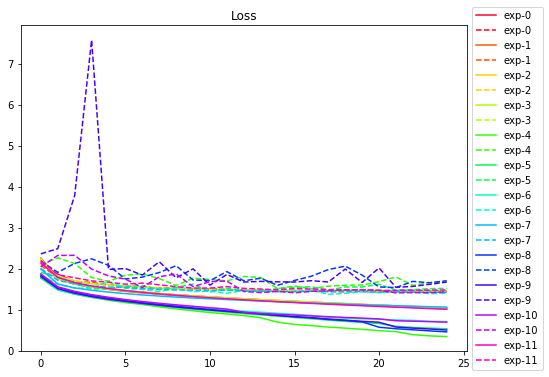

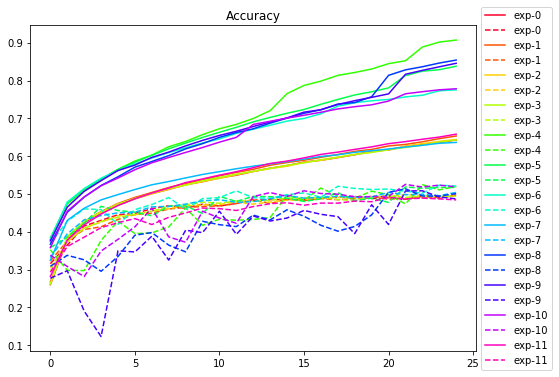

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()